# 13. `dask`：大型資料處理

一般認為所謂大型資料或「大數據 (Big Data)」通常應用在機器學習領域上，但在大氣科學上，我們所認定的大數據可能更接近以下維基百科的定義：

> Big data is data sets that are so voluminous and complex that traditional data processing application software are inadequate to deal with them.

大氣科學資料因為時間長、網格解析度和垂直層越來越細的緣故，如果沒有謹慎處理，可能會造成記憶體無法負荷，例如以下錯誤訊息：

`MemoryError: Unable to allocate 52.2 GiB for an array with shape (365, 37, 721, 1440) and data type float32`

會有這樣的情形是因為要分析的資料量已經超過電腦記憶體 (RAM) 的負荷。那要如何避免這個情形發生呢？

## Dask 

Dask是一套Python的套件，可以用電腦多核心(core)來進行平行運算，因此可以提升效率。在計算時，程式不會完全讀入所有的資料，而是以符號的方式先進行運算，這個過程稱為 "lazy computation"，也因此運算的過程不會耗費大量的記憶體 RAM。

為了理解dask如何在xarray上運作，我們先以一組1000 × 4000大小的矩陣來示範。

**1. Numpy矩陣**

In [1]:
import numpy as np

shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

**2. Dask矩陣**

In [2]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

![](https://docs.dask.org/en/latest/_images/dask-array.svg)

Dask會把矩陣分成許多子矩陣，這些子矩陣稱為"chunk"。在dask中，我們可以指定chunks的大小。

In [3]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

如果我們做點計算，例如先進行相乘然後再平均

In [4]:
ones_mean = (ones * ones[::-1, ::-1]).mean()
ones_mean

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

計算過程如下：

![](https://earth-env-data-science.github.io/_images/dask_arrays_16_0.png)

Dask 允許在每個記憶體核心中分塊（chunk）計算，最後再將各個分塊的結果組合成最終輸出。

Dask 已與 NumPy 和 xarray 等常用函式庫整合，這對於處理氣候資料特別有幫助。那麼，Dask 是如何協助處理大型資料集的呢？在接下來的章節中，我們將示範兩種工作流程，說明如何善用 Dask 來提升計算效率。

## Dask 初始設定

進行主要計算之前，先加上以下這段程式碼。

In [ ]:
from dask import delayed, compute
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(threads_per_worker=1, memory_limit=0)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:46085' processes=64 threads=64>

- 本地主機工作叢集 `LocalCluster`: 用以在本地主機上，設定多個 **工作進程 (workers)** 來平行運算。 Used to start multiple workers on the local machine for parallel computation
- `cluster = LocalCluster(threads_per_worker=1, memory_limit=0)`: 這行程式產生本地主機的 **工作任務叢集 (cluster)**，叢集中每個工作進程使用單一 **執行緒 (thread)**。 Creates a local cluster where each worker runs on a single thread.   
  記憶體 RAM 的上限設為0，代表沒有限制。但要小心，如果資料太大或程式沒有妥善設計，記憶體無上限會導致RAM過載，實際上我們也可以設定RAM的上限來保護主機系統，如 `"4GB"`, `"8GB"`, `"16GB"`。
- `client = Client(cluster)`: 用來啟動用戶端物件，以和叢集連接溝通，這能確保Dask在計算 (如：載入大型NetCDF、GRIB資料，或延遲計算) 的時候，會透過排程器 **排程器 (scheduler)** 分配工作給工作進程 (workers)。 Initializes a client object that communicates with the cluster. This ensures all Dask operations (e.g., loading large NetCDF/GRIB files with xarray, or delayed computations) are distributed to the workers via the scheduler.

在上方用戶端資訊中，Client Dashboard 有一個超連結，可以點連結來即時監控本地的運算叢集。

![](https://tutorial.dask.org/_images/distributed-overview.png)

## 大型氣候資料處理

在第二單元中，我們介紹用`xarray.open_mfdataset`開啟檔案時有 `parallel=True` 選項，這會讓xarray開啟檔案時自動使用 `dask` 延遲讀資料。

In [ ]:
import xarray as xr

u = xr.open_mfdataset('./data/ncep_r2_uv850/u850.*.nc',
                           combine = "by_coords",               
                           parallel=True,
                         ).uwnd
v = xr.open_mfdataset('data/ncep_r2_uv850/v850.*.nc',
                           combine = "by_coords",               
                           parallel=True,
                         ).vwnd
u

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 73, lon: 144)> Size: 369MB
dask.array<concatenate, shape=(8766, 1, 73, 144), dtype=float32, chunksize=(366, 1, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

此時，`u` 是一個 由 Dask 支援的 DataArray，而不是一個完整載入記憶體的 NumPy 陣列。到目前為止，實際的資料還沒有被讀入 RAM。這個 DataArray 只儲存了中繼資料：維度 (dimensions)、座標 (coordinates)、資料型態 (data type)、以及分塊資訊 (chunking info)。因此，無論 NetCDF 檔案有多大，`u` 本身的大小都非常小（通常只有幾 MB）。

雖然在使用 `xr.open_mfdataset()` 時，xarray 會自動將資料進行分塊 (chunking)，但你仍然可以手動重新分塊 (rechunk)，例如：

In [ ]:
from xarray.groupers import TimeResampler

u_rechunk = u.chunk({'time': TimeResampler("YS"), 'lon': 36, 'lat': 24})
u_rechunk

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 73, lon: 144)> Size: 369MB
dask.array<rechunk-p2p, shape=(8766, 1, 73, 144), dtype=float32, chunksize=(366, 1, 24, 36), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

手動重新分塊（rechunking）在資料非常大時特別有用，因為有時自動分塊會產生太多小塊，導致 Dask 運算時產生過多計算任務，需要調度大量的運算資源。實務上的分塊大小的建議如下：
- 盡可能將每個分塊控制在 50–200 MB。這樣大小足以減少計算任務、減少運算資源調度，同時又能將資料載入 RAM。
- 避免在某個維度上有過多分塊（例如數百或數千個），因為 Dask 必須將每個分塊視為獨立的計算任務，太多分塊可能會降低計算速度。

更多關於如何選擇適合分塊大小的細節，可參考[這裡](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes?utm_source=xarray-docs)。

```{note}
可以使用 `ds.chunk(time=TimeResampler())` 以根據完整時間單位進行重新分塊，例如 `ds.chunk(time=TimeResampler("MS"))` 會以月為單位來切塊。
```

### `.compute()`

原本被延遲計算的資料，會因為 `.compute()` 觸發計算，將資料載入RAM。因此，若能將很大的NetCDF或GRIB資料先切小資料範圍，再觸發 `.compute()` 讀入RAM的話，可以避免記憶體過載。

In [ ]:
u_slice = u.sel(lat=slice(90,0)).compute()
v_slice = v.sel(lat=slice(90,0)).compute()
u_slice

<xarray.DataArray 'uwnd' (time: 8766, level: 1, lat: 37, lon: 144)> Size: 187MB
array([[[[ -7.9900055 ,  -7.9600067 ,  -7.9400024 , ...,  -7.9799957 ,
           -7.9600067 ,  -8.0099945 ],
         [ -3.5800018 ,  -3.2900085 ,  -3.0099945 , ...,  -4.5099945 ,
           -4.2100067 ,  -3.8600006 ],
         [  4.1900024 ,   4.669998  ,   5.050003  , ...,   2.4199982 ,
            3.069992  ,   3.699997  ],
         ...,
         [ -2.5400085 ,  -3.6100006 ,  -4.1600037 , ...,   0.6199951 ,
           -0.21000671,  -1.3399963 ],
         [ -4.1100006 ,  -4.630005  ,  -4.3099976 , ...,  -0.29000854,
           -1.4900055 ,  -2.9100037 ],
         [ -7.4600067 ,  -7.3899994 ,  -6.1900024 , ...,  -3.6600037 ,
           -5.2299957 ,  -6.6100006 ]]],


       [[[ -5.6100006 ,  -5.1600037 ,  -4.7100067 , ...,  -6.8099976 ,
           -6.4100037 ,  -6.0099945 ],
         [  2.2200012 ,   2.6699982 ,   3.069992  , ...,   0.56999207,
            1.199997  ,   1.6900024 ],
         [  8.319992  ,   8.789993  ,   9.139999  , ...,   6.369995  ,
...
            1.6250005 ,   1.9250002 ],
         [ -1.2750001 ,  -0.7999997 ,  -0.2249999 , ...,  -2.7249997 ,
           -2.2       ,  -1.7499998 ],
         [ -3.9249995 ,  -3.4999998 ,  -2.9250002 , ...,  -5.4       ,
           -4.975     ,  -4.5       ]]],


       [[[ -6.7499995 ,  -6.775     ,  -6.8250003 , ...,  -6.6       ,
           -6.625     ,  -6.7249994 ],
         [ -6.8749995 ,  -6.925     ,  -6.9499993 , ...,  -6.575     ,
           -6.675     ,  -6.775     ],
         [ -7.05      ,  -7.175     ,  -7.225     , ...,  -6.5000005 ,
           -6.725     ,  -6.8749995 ],
         ...,
         [ -0.625     ,  -0.8500004 ,  -0.5750003 , ...,  -2.6       ,
           -1.5500002 ,  -0.7249999 ],
         [ -1.6749997 ,  -1.3499999 ,  -1.2750001 , ...,  -5.9500003 ,
           -4.4749994 ,  -2.775     ],
         [ -3.15      ,  -2.8249998 ,  -2.8250003 , ...,  -7.700001  ,
           -6.125     ,  -4.3       ]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 148B 90.0 87.5 85.0 82.5 80.0 ... 7.5 5.0 2.5 0.0
  * level    (level) float32 4B 850.0
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

因為Dask和 `numpy`和`xarray`整合得很好，所以使用Xarray內建函數計算過後再觸發 `.compute()`，也可以提升資料計算和載入的效率。例如，若想計算風場的時間平均，可以

In [ ]:
u_mean = u.mean(axis=0).compute()
v_mean = v.mean(axis=0).compute()
u_mean

<xarray.DataArray 'uwnd' (level: 1, lat: 73, lon: 144)> Size: 42kB
array([[[-0.633123  , -0.647495  , -0.660538  , ..., -0.58317655,
         -0.60082316, -0.61727756],
        [-0.25697124, -0.2630875 , -0.26836646, ..., -0.23004168,
         -0.24033782, -0.24917528],
        [ 0.04172542,  0.02860714,  0.02494916, ...,  0.14124975,
          0.0976802 ,  0.06451849],
        ...,
        [-5.6017437 , -5.16407   , -4.7215905 , ..., -6.8395767 ,
         -6.444315  , -6.0301476 ],
        [-4.247105  , -3.8827536 , -3.5130305 , ..., -5.2855477 ,
         -4.949826  , -4.6035438 ],
        [ 0.21703638,  0.56360835,  0.9087125 , ..., -0.82172674,
         -0.47649175, -0.12961623]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 4B 850.0

### `.persist()`

所有的 `.compute()` 指令會觸發完整的程序：從讀入原本NetCDF/GRIB資料開始，到資料切塊、進行中間運算、產生最終結果。如果我們使用同個變數，卻進行了許多次不同的函數運算，例如 

```python
umean = u.mean(axis=0).compute()
uvar  = u.var(axis=0).compute()
umed  = u.median(axis=0).compute()
umax  = u.max(axis=0).compute()
umin  = u.min(axis=0).compute()
```

則每一行使用到 `u` 時，都會重複從讀資料到產生最終結果的過程，造成許多多餘的計算過程，計算並無效率。因此，`.persist()` 會觸發計算任務圖 (task graph) 的一部分，並將計算得到的分塊存放在叢集工作節點的記憶體（in the cluster workers' memory, or RAM）中。接下來只要使用到`u`，就會直接使用已經存在記憶體的、persisted 的`u`區塊 (如下例的`u_persist`)，避免過度重複的計算。

In [ ]:
u_persist = u.persist()
v_persist = v.persist()

總結來說，若有一個核心的、需要使用多次的變數 (像上例的`u`)，我們可以使用`.persist()` 指令。但也要特別小心工作進程的記憶體使用，如果資料非常大，persist的過程可能會占滿RAM。建議進行重新分塊，或是切更小的區塊來persist。

**Example 1:** 計算 `u` 和 `v` 的日氣候場。

我們會使用第11章學的 [`flox.xarray.xarray_reduce`](https://flox.readthedocs.io/en/latest/generated/flox.xarray.xarray_reduce.html) 套件計算，其中輸入的風場資料我們用persisted的變數。

In [ ]:
from flox.xarray import xarray_reduce

uDayClm = xarray_reduce(u_persist,
                        u_persist.time.dt.dayofyear,
                        func='mean',dim='time')
vDayClm = xarray_reduce(v_persist,
                        v_persist.time.dt.dayofyear,
                        func='mean',dim='time')
uDayClm 

<xarray.DataArray 'uwnd' (dayofyear: 366, level: 1, lat: 73, lon: 144)> Size: 15MB
dask.array<transpose, shape=(366, 1, 73, 144), dtype=float32, chunksize=(366, 1, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float32 4B 850.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

經過前面的延遲計算 (lazy computation)，我們最終可以利用`.compute()`觸發計算並回傳結果。

In [ ]:
uDayClm_fn = uDayClm.compute()
vDayClm_fn = vDayClm.compute()

uDayClm_fn

<xarray.DataArray 'uwnd' (dayofyear: 366, level: 1, lat: 73, lon: 144)> Size: 15MB
array([[[[-1.5247937e+00, -1.4514604e+00, -1.3754172e+00, ...,
          -1.7235428e+00, -1.6562518e+00, -1.5960444e+00],
         [-5.6333429e-01, -4.1833475e-01, -2.7458504e-01, ...,
          -9.6874976e-01, -8.4125155e-01, -6.9416922e-01],
         [ 7.5583190e-01,  9.2770594e-01,  1.0993727e+00, ...,
           3.0166462e-01,  4.4770643e-01,  6.0145718e-01],
         ...,
         [-2.1635435e+00, -1.9181260e+00, -1.6775018e+00, ...,
          -2.8645859e+00, -2.6393764e+00, -2.4029195e+00],
         [-2.3662536e+00, -2.1679192e+00, -1.9677110e+00, ...,
          -2.9314604e+00, -2.7418773e+00, -2.5595868e+00],
         [-7.0416862e-01, -5.3041750e-01, -3.5291770e-01, ...,
          -1.2106274e+00, -1.0472922e+00, -8.7396073e-01]]],


       [[[ 1.3624781e-01,  1.8458217e-01,  2.3916422e-01, ...,
          -1.3961315e-02,  3.6873043e-02,  8.3957411e-02],
         [ 2.3895724e-01,  3.3770636e-01,  4.3708053e-01, ...,
          -5.7292778e-02,  4.5207102e-02,  1.4082973e-01],
         [ 2.3937146e-01,  3.5499719e-01,  4.8520657e-01, ...,
...
         [-2.1402094e+00, -1.9437499e+00, -1.7400008e+00, ...,
          -2.7075014e+00, -2.5300019e+00, -2.3356268e+00],
         [-2.5000751e-02,  1.4437424e-01,  3.1728974e-01, ...,
          -5.3333282e-01, -3.6312675e-01, -1.9583400e-01]]],


       [[[-4.1091676e+00, -3.9441681e+00, -3.7783356e+00, ...,
          -4.5566688e+00, -4.4050002e+00, -4.2674980e+00],
         [-3.2116699e+00, -3.1075017e+00, -2.9991691e+00, ...,
          -3.5141671e+00, -3.4233353e+00, -3.3258324e+00],
         [-3.0250015e+00, -3.1033335e+00, -3.1783364e+00, ...,
          -2.5975020e+00, -2.7550004e+00, -2.8883379e+00],
         ...,
         [-2.2550049e+00, -1.9391688e+00, -1.6375014e+00, ...,
          -3.1650000e+00, -2.8641689e+00, -2.5591679e+00],
         [-1.5691684e+00, -1.3050017e+00, -1.0416707e+00, ...,
          -2.3041666e+00, -2.0675030e+00, -1.8150015e+00],
         [ 1.0366653e+00,  1.2341684e+00,  1.4316640e+00, ...,
           4.0583149e-01,  6.1833334e-01,  8.4499711e-01]]]],
      dtype=float32)
Coordinates:
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float32 4B 850.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes: (12/14)
    standard_name:         eastward_wind
    long_name:             Daily U-wind on Pressure Levels
    units:                 m/s
    unpacked_valid_range:  [-140.  175.]
    actual_range:          [-78.96 110.35]
    precision:             2
    ...                    ...
    var_desc:              u-wind
    dataset:               NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily A...
    level_desc:            Pressure Levels
    statistic:             Mean
    parent_stat:           Individual Obs
    cell_methods:          time: mean (of 4 6-hourly values in one day)

現在計算結果已經儲存為DataArray了。

### 小結

在以上的範例中，我們所使用的資料很小，所以`persist()`、延遲計算的好處也許並不明顯。但如果照著以下的步驟

1. 使用Dask延遲開啟載入資料、
2. 決定切塊的策略、  
3. 使用 `.persist()` 來儲存多次使用的核心變數。   
4. 當最終結果需要被輸出使用時，觸發 `.compute()`。  

在處理大型氣候資料 (如高解析ERA5再分析資料、年代際的CMIP6模式資料、高解析系集預報模式輸出GEFSv12資料)，這樣的流程可以提升計算效率。

## 平行化計算迴圈 

有時候內建函式無法涵蓋所有的分析流程，因此必須透過撰寫較複雜的迴圈來完成。但若逐一執行迴圈，往往會非常耗時。這時候，我們可以將迴圈中會重複運算的部分包裝成一個函數，並利用 Dask 將任務分配給不同的計算核心來平行化處理。舉例來說，如果迴圈逐一計算需要重複 8 次，那麼 Dask 可以把這 8 次計算同時分配給 8 個核心平行運算。在理想狀況下，總耗時就會縮短為大約原本的 1/8。

**Example 2:** 繪製MJO 8個相位的冬季 (DJF) 合成平均降雨和850百帕風場。 

**Step 1:** 從 [IRI data library](https://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/datasetdatafiles.html?Set-Language=en) 下載澳洲氣象局 (Bureau of Meteorology, BoM) 的RMM相位資料。

In [ ]:
import pandas as pd

# Read MJO data
mjo_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/dods',
                         decode_times=False)

T = mjo_ds.T.values
mjo_ds['T'] = pd.date_range("1974-06-01", periods=len(T))  # 資料的起始時間為1974-06-01

mjo_sig_phase = xr.where(mjo_ds.amplitude>=1,  mjo_ds.phase, 0)
mjo_slice = mjo_sig_phase.sel(T=slice("1998-01-01","2020-12-31"))
mjo_djf = mjo_slice.sel(T=mjo_slice['T'].dt.month.isin([12, 1, 2]))

syntax error, unexpected WORD_STRING, expecting ';' or ','
context: Attributes { T { String calendar "standard"; Int32 expires 1755648000; String standard_name "time"; Float32 pointwidth 1.0; Int32 gridtype 0; String units "julian_day"; } amplitude { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; } phase { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 999.0; } RMM1 { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; } RMM2 { Int32 expires 1755648000; String units "unitless"; Float32 missing_value 9.99999962E35; }NC_GLOBAL { String references "Wheeler_Hendon2004"; Int32 expires 1755648000; URL data source "http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt"^; String description "Real-time Multivariate MJO Index (with components of interannual variability removed)"; URL summary from BoM "http://www.bom.gov.au/climate/mjo/"; URL Wheeler and Hendon (2004) Monthly Weather R

**Step 2:** 讀資料、計算距平場。 

In [ ]:
def calc_anml_slice(da): 
    da_slice = da.sel(time=slice("1998-01-01","2020-12-31"),lat=slice(20,-20),lon=slice(40,180)).chunk({'time': TimeResampler("YS")})
    da_anml = da_slice.groupby('time.dayofyear') - da_slice.groupby('time.dayofyear').mean('time')  # Anomaly
    da_djf = da_anml.sel(time=da_anml.time.dt.month.isin([12, 1, 2])) 
    return da_djf

pcp = xr.open_dataset('./data/cmorph_sample.nc').cmorph
pcp = pcp[:,::-1,:]  # Re-order latitude from north to south (same as u and v)

# Calculate OLR and wind anomaly 
pcpa = calc_anml_slice(pcp)
ua   = calc_anml_slice(u.isel(level=0))
va   = calc_anml_slice(v.isel(level=0))

pcpa

<xarray.DataArray 'cmorph' (time: 2076, lat: 160, lon: 560)> Size: 744MB
dask.array<getitem, shape=(2076, 160, 560), dtype=float32, chunksize=(216, 160, 560), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 17kB 1998-01-01 1998-01-02 ... 2020-12-31
  * lon        (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat        (lat) float32 640B 19.88 19.62 19.38 ... -19.38 -19.62 -19.88
    dayofyear  (time) int64 17kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

### 依序迴圈計算

**Step 3:** 計算各變數MJO相位的合成平均。 

我們先示範如何利用迴圈依序計算。

In [ ]:
mjo_pcp, mjo_u, mjo_v = [], [], []

for i in range(1,9):
    mjo_phase = xr.where(mjo_djf==i, mjo_djf, np.nan).dropna(dim='T')
    time = mjo_phase['T']
    
    pcp_compo_mean = (pcpa.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[i],axis=0))
    u_compo_mean = (ua.loc[time,:,:]
                      .mean(axis=0)
                      .expand_dims(phase=[i],axis=0))
    v_compo_mean = (va.loc[time,:,:]
                      .mean(axis=0)
                      .expand_dims(phase=[i],axis=0))
    
    mjo_pcp.append(pcp_compo_mean)
    mjo_u.append(u_compo_mean)
    mjo_v.append(v_compo_mean)

mjo_pcp_fn = xr.concat(mjo_pcp, dim='phase').compute()
mjo_u_fn = xr.concat(mjo_u, dim='phase').compute()
mjo_v_fn = xr.concat(mjo_v, dim='phase').compute()

mjo_pcp_fn

<xarray.DataArray 'cmorph' (phase: 8, lat: 160, lon: 560)> Size: 3MB
array([[[ 1.1642029 ,  1.7967764 ,  1.6354021 , ..., -0.49765617,
         -0.52265364, -0.3197551 ],
        [ 0.4289805 ,  0.5675261 ,  0.7982411 , ..., -0.37138933,
         -0.37802598, -0.2736282 ],
        [ 0.34693143,  0.09691156,  0.4446028 , ..., -0.274023  ,
         -0.31316844, -0.3483858 ],
        ...,
        [-0.26494256,  0.6725488 ,  0.36411816, ..., -3.3324733 ,
         -2.380455  , -2.077746  ],
        [ 0.2235834 ,  0.666082  ,  0.08555231, ..., -2.9516845 ,
         -2.7592201 , -2.5683365 ],
        [ 1.033728  ,  1.054208  ,  0.6711898 , ..., -2.9339333 ,
         -2.7459626 , -2.7602105 ]],

       [[-0.2819479 , -0.35855076, -0.27372763, ..., -0.42099413,
         -0.44489563, -0.30963767],
        [-0.22117391, -0.26832473, -0.27131033, ..., -0.4018956 ,
         -0.39008692, -0.34509283],
        [-0.20414495, -0.23193039, -0.24091023, ..., -0.12682611,
         -0.26710433, -0.2954261 ],
...
        [ 2.318648  ,  1.3489722 ,  0.8619659 , ...,  1.837919  ,
          1.5916772 ,  0.8387357 ],
        [ 2.0905535 ,  1.4776336 ,  1.1018339 , ...,  1.8853862 ,
          1.351057  ,  0.982385  ],
        [ 1.9134518 ,  1.6720352 ,  1.401461  , ...,  1.6543014 ,
          1.0584089 ,  1.0382332 ]],

       [[ 0.9606286 ,  0.6415049 ,  0.3561331 , ..., -0.59736055,
         -0.61483186, -0.6769132 ],
        [ 0.6706844 ,  0.565837  ,  0.70489025, ..., -0.6471602 ,
         -0.67367876, -0.69084775],
        [ 0.47901937,  0.6756892 ,  0.75941104, ..., -0.7043601 ,
         -0.71212757, -0.65451425],
        ...,
        [ 1.3432965 ,  1.0880604 ,  0.6569935 , ..., -1.3948476 ,
         -1.3313782 , -1.1290971 ],
        [ 1.608773  ,  1.8569999 ,  1.5715383 , ..., -1.7065433 ,
         -0.95375925, -0.62605035],
        [ 2.4226344 ,  2.9898245 ,  2.7392473 , ..., -2.171187  ,
         -1.9004679 , -1.6571506 ]]], dtype=float32)
Coordinates:
  * phase    (phase) int64 64B 1 2 3 4 5 6 7 8
  * lon      (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat      (lat) float32 640B 19.88 19.62 19.38 19.12 ... -19.38 -19.62 -19.88

這邊是一個相位一個相位依序計算，且只有用到一個工作進程 (worker)。

### 平行迴圈計算進程

既然迴圈內每個相位的計算過程和結果是互相獨立的，我們可以將迴圈的內容，分配給dask進行平行計算。

1. 將合成平均的過程包裝成一個函數 (如下面示範中的 `compute_phase_composite()`)。 
2. 利用 `dask.delayed` 讓`compute_phase_composite()`被延遲，不觸發實際的計算 (dask會將8次的迴圈，透過排程器scheduler 分配給8個核心)。
3. 最後一次觸發 `compute()` ，這樣dask就會按照排程器 sheduler 規劃好的工作圖 (task graph)，分配給不同的工作進程 worker 計算。 

In [ ]:
from dask import delayed, compute

@delayed
def compute_phase_composite(phase, mjo_djf, pcpa, ua, va):
    """Compute composite mean for one MJO phase"""
    mjo_phase = xr.where(mjo_djf == phase, mjo_djf, np.nan).dropna(dim='T')
    time = mjo_phase['T']

    pcp_compo_mean = (pcpa.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    u_compo_mean   = (ua.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    v_compo_mean   = (va.loc[time,:,:]
                          .mean(axis=0)
                          .expand_dims(phase=[phase], axis=0))
    
    return pcp_compo_mean, u_compo_mean, v_compo_mean

# build delayed tasks for each phase
tasks = [compute_phase_composite(i, mjo_djf, pcpa, ua, va) for i in range(1, 9)]

# execute all phases in parallel
results = compute(*tasks)

# unpack results
mjo_pcp_list, mjo_u_list, mjo_v_list = zip(*results)

# concat along phase dimension
mjo_pcp_fn = xr.concat(mjo_pcp_list, dim='phase')
mjo_u_fn   = xr.concat(mjo_u_list, dim='phase')
mjo_v_fn   = xr.concat(mjo_v_list, dim='phase')

mjo_pcp_fn


<xarray.DataArray 'cmorph' (phase: 8, lat: 160, lon: 560)> Size: 3MB
array([[[ 1.1642029 ,  1.7967764 ,  1.6354021 , ..., -0.49765617,
         -0.52265364, -0.3197551 ],
        [ 0.4289805 ,  0.5675261 ,  0.7982411 , ..., -0.37138933,
         -0.37802598, -0.2736282 ],
        [ 0.34693143,  0.09691156,  0.4446028 , ..., -0.274023  ,
         -0.31316844, -0.3483858 ],
        ...,
        [-0.26494256,  0.6725488 ,  0.36411816, ..., -3.3324733 ,
         -2.380455  , -2.077746  ],
        [ 0.2235834 ,  0.666082  ,  0.08555231, ..., -2.9516845 ,
         -2.7592201 , -2.5683365 ],
        [ 1.033728  ,  1.054208  ,  0.6711898 , ..., -2.9339333 ,
         -2.7459626 , -2.7602105 ]],

       [[-0.2819479 , -0.35855076, -0.27372763, ..., -0.42099413,
         -0.44489563, -0.30963767],
        [-0.22117391, -0.26832473, -0.27131033, ..., -0.4018956 ,
         -0.39008692, -0.34509283],
        [-0.20414495, -0.23193039, -0.24091023, ..., -0.12682611,
         -0.26710433, -0.2954261 ],
...
        [ 2.3186479 ,  1.3489723 ,  0.8619657 , ...,  1.8379189 ,
          1.5916773 ,  0.8387354 ],
        [ 2.0905535 ,  1.4776337 ,  1.1018339 , ...,  1.8853862 ,
          1.351057  ,  0.9823849 ],
        [ 1.913452  ,  1.6720352 ,  1.4014612 , ...,  1.6543014 ,
          1.0584089 ,  1.0382335 ]],

       [[ 0.9606286 ,  0.6415049 ,  0.3561331 , ..., -0.59736055,
         -0.61483186, -0.6769132 ],
        [ 0.6706844 ,  0.565837  ,  0.70489025, ..., -0.6471602 ,
         -0.67367876, -0.69084775],
        [ 0.47901937,  0.6756892 ,  0.75941104, ..., -0.7043601 ,
         -0.71212757, -0.65451425],
        ...,
        [ 1.3432965 ,  1.0880604 ,  0.6569935 , ..., -1.3948476 ,
         -1.3313782 , -1.1290971 ],
        [ 1.608773  ,  1.8569999 ,  1.5715383 , ..., -1.7065433 ,
         -0.95375925, -0.62605035],
        [ 2.4226344 ,  2.9898245 ,  2.7392473 , ..., -2.171187  ,
         -1.9004679 , -1.6571506 ]]], dtype=float32)
Coordinates:
  * phase    (phase) int64 64B 1 2 3 4 5 6 7 8
  * lon      (lon) float32 2kB 40.12 40.38 40.62 40.88 ... 179.4 179.6 179.9
  * lat      (lat) float32 640B 19.88 19.62 19.38 19.12 ... -19.38 -19.62 -19.88

在 `compute_phase_composite()` 函式前加上 `@delayed` decorator，可以將一個普通的 Python 函式轉換成延遲執行的任務。一般情況下，在 Python 中呼叫函式時，會立即執行並回傳結果；但加上 @delayed 後，函式呼叫不會馬上執行，而是回傳一個 Delayed 物件，代表計算圖中的一個任務。

當在迴圈中收集許多 Delayed 物件時，Dask 會建立完整的任務圖。實際的計算只有在明確呼叫 `.compute()`（或 `dask.compute()`）時才會發生，這時候 Dask 會將任務分派到多個工作進程，平行執行這些任務。

```{note}
在這個 MJO 合成平均分析的範例中，迴圈內的計算任務其實並不繁重，僅僅是從變數中篩選出符合條件（MJO 相位）的時間，然後在時間軸上取平均並回傳結果。由於這類計算任務相當輕量，因此即使事先將任務交給 Dask 排程，所花費的時間與直接依序計算相比差異並不大。

然而，當資料量龐大，或計算任務需要消耗大量效能時，使用 @delayed 或 Dask array 所帶來的效能提升就會非常明顯。

因此，這個範例的主要目的，是示範如何將原本依序執行的迴圈改寫成平行計算的架構。未來在處理大型資料時，便能透過這種方法獲得顯著的效能改善。
```


**Step 4:** Plotting

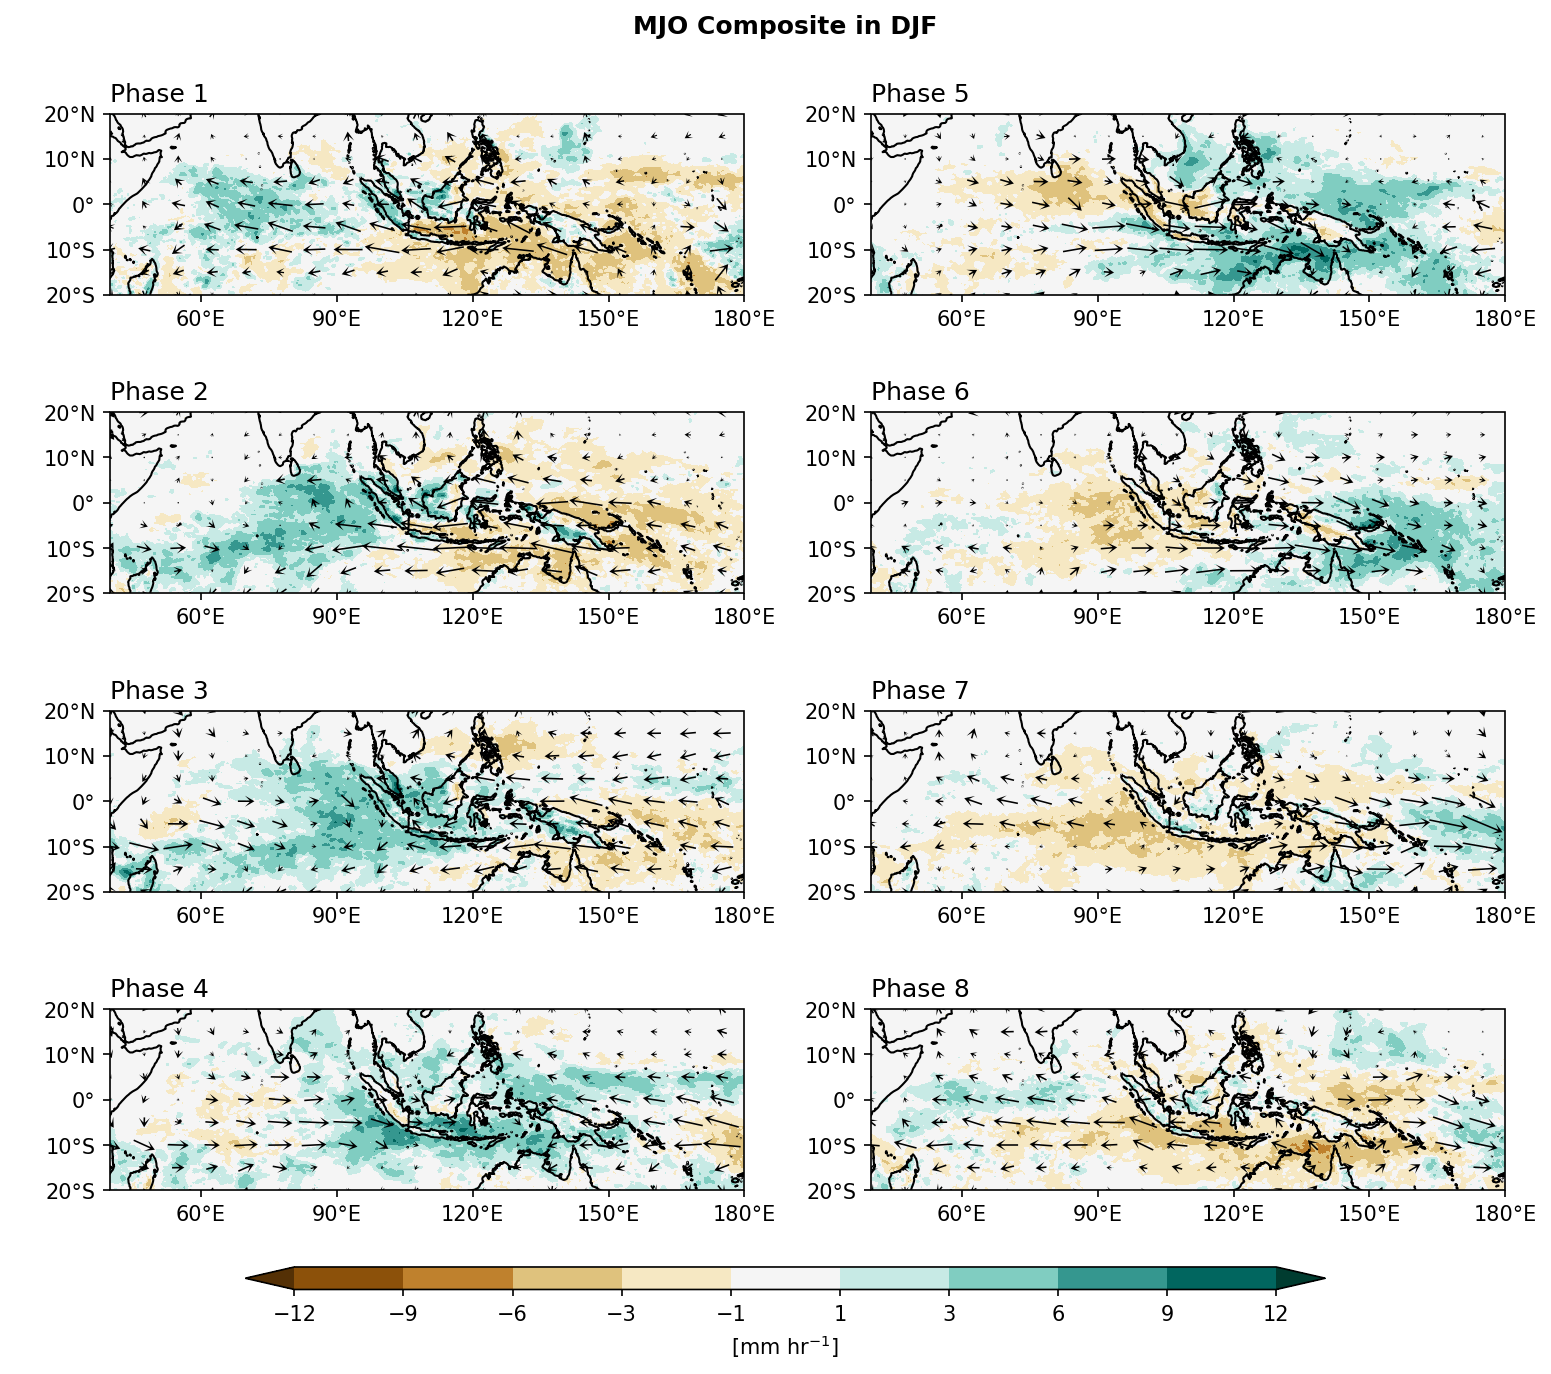

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmaps
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(4,2, 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(12,10))
ax = axes.flatten()
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER

clevs = [-12,-9,-6,-3,-1,1,3,6,9,12]

porder = [0,2,4,6,1,3,5,7]

for i in range(0,8): 
    cf = (mjo_pcp_fn[i,:,:].plot.contourf(x='lon',y='lat', ax=ax[porder[i]],
                                         levels=clevs,
                                         add_colorbar=False,
                                         cmap=cmaps.CBR_drywet, 
                                         extend='both',
                                         transform=ccrs.PlateCarree()))
    wnd = xr.merge([mjo_u_fn[i,::2,::3], mjo_v_fn[i,::2,::3]])
    qv = wnd.plot.quiver(ax=ax[porder[i]],
                         transform=ccrs.PlateCarree(),
                         x='lon', y='lat',
                         u='uwnd', v='vwnd',
                         add_guide=False,
                         width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                         scale=70, colors="black"
                         )
    
    ax[porder[i]].coastlines()
    ax[porder[i]].set_extent([40,180,-20,20],crs=ccrs.PlateCarree())
    ax[porder[i]].set_xticks(np.arange(60,210,30), crs=ccrs.PlateCarree())
    ax[porder[i]].set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())   # 設定x, y座標的範圍，以及多少經緯度繪製刻度。
    ax[porder[i]].xaxis.set_major_formatter(lon_formatter)
    ax[porder[i]].yaxis.set_major_formatter(lat_formatter)
    ax[porder[i]].set_xlabel(' ')
    ax[porder[i]].set_ylabel(' ')
    ax[porder[i]].set_title(' ')
    ax[porder[i]].set_title('Phase '+str(i+1), loc='left')
    
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.015])
# Draw the colorbar 將colorbar畫在cbar_ax這個軸上。
cbar = fig.colorbar(cf, cax=cbar_ax,
                    orientation='horizontal',
                    ticks=clevs,
                    label=r'[mm hr$^{-1}$]')  

plt.subplots_adjust(hspace=0.15)
plt.suptitle('MJO Composite in DJF',y=0.92,size='large',weight='bold')
plt.show()    